# Imports, auxiliar functions

In [202]:
import importlib
import adaptive_RK as aRK
import numpy as np
import matplotlib.pyplot as plt
import math

In [203]:
# Plots the solution, step sizes and the exact solution if provided
def plot_solution(t, y, step_sizes, method="", exact_solution=None):
    y = np.array(y)
    plt.figure(figsize=(15, 6))
    plt.plot(t, y[:, 0], label='y1 (approx)')
    if len(y[0]) > 1:
        plt.plot(t, y[:, 1], label='y2 (approx)')
    
    if exact_solution([0]) is not None:
        y_exact = np.array([exact_solution(ti) for ti in t])
        # print(y_exact)
        k = y_exact.shape[1]

        plt.plot(t, y_exact[:, 0], 'r--', label='y1 (exact)')
        if k > 1:
            plt.plot(t, y_exact[:, 1], 'g--', label='y2 (exact)')
    
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'Adaptive Runge-Kutta Solution using {method}')
    plt.grid()
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(t, step_sizes, label='step sizes')
    plt.yscale('log') 
    
    plt.xlabel('t')
    plt.ylabel('step size')
    plt.legend()
    plt.title('Step sizes (only accepted steps)')
    plt.grid()
    plt.show()

def set_Fehlberg_tableau():
    A = np.array([
        [0., 0., 0., 0., 0., 0.],
        [1/4, 0., 0., 0., 0., 0.],
        [3/32, 9/32, 0., 0., 0., 0.],
        [1932/2197, -7200/2197, 7296/2197, 0., 0., 0.],
        [439/216, -8., 3680/513, -845/4104, 0., 0.],
        [-8/27, 2., -3544/2565, 1859/4104, -11/40, 0.]
    ])

    c = np.array([0.,1/4,3/8,12/13,1.,1/2])

    b1 = np.array([16/135,0.,6656/12825,28561/56430,-9/50,2/55])
    b2 = np.array([25/216,0.,1408/2565,2197/4104,-1/5,0.])

    return A, b1, b2, c

def print_acceptance_stats(method, cnt_accepted, cnt_rejected):
    total_steps = cnt_accepted + cnt_rejected
    acceptance_ratio = cnt_accepted / total_steps if total_steps > 0 else 0
    print(f"{method} method: Accepted steps = {cnt_accepted}, Rejected steps = {cnt_rejected}, Acceptance ratio = {acceptance_ratio:.2f}")

# Problem definition

In [204]:
# We will solve the ODE sytem on interval [0, t_f]
t_f = 20

# Definition of the ODE system
def f(t, y):
    mu = 1.0 
    return [
        y[1],
        mu * (1 - y[0]**2) * y[1] - y[0]
    ]

# Initial values (aka values at t=0)
def start_values():
    return [2.0, 0.0]

# If an exact solution is known, it can be defined here for error analysis/plotting
def exact_solution(t):
    return None

# Using the methods provided

The following methods are provided in the package adaptive_RK:
- the classical adaptive Runge-Kutta method, using either Richardson-extrapolation (`adaptive_Richardson_RK`) or embedded Runge-Kutta method  (`embedded_adaptive_RK`)
- we can use controllers with embedded Runge-Kutta methods (`adaptive_RK_with_controller`). We should specify the controller type. The following controllers are implemented: I, PI, PID, PI3333, H211  

## Fehlberg method

In [205]:
# Fehlberg tableau
A, b1, b2, c = set_Fehlberg_tableau()

0.1
Fehlberg method: Accepted steps = 182, Rejected steps = 37, Acceptance ratio = 0.83


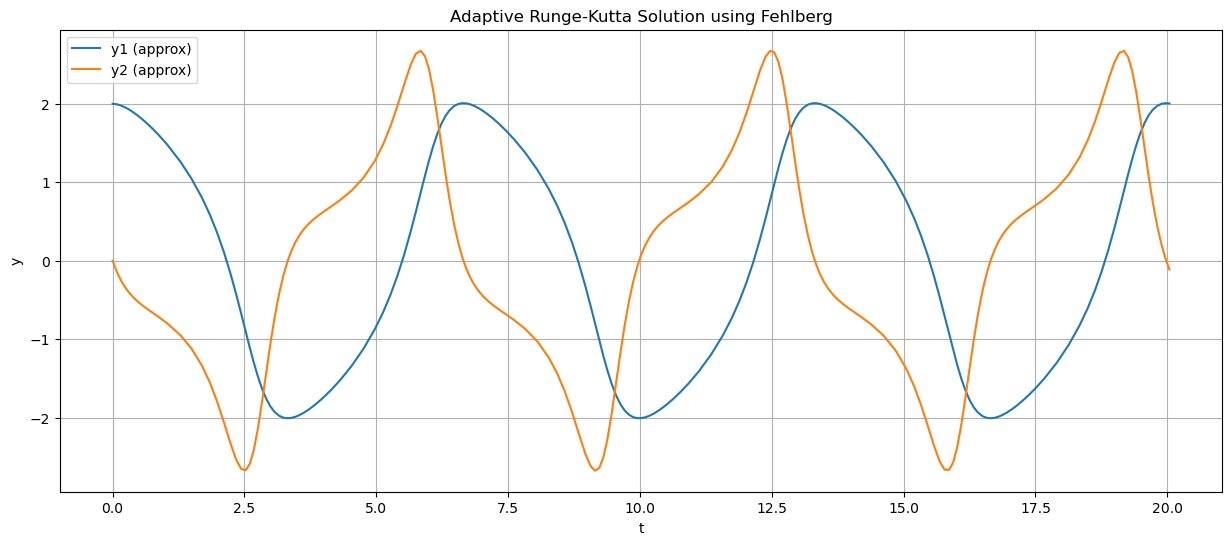

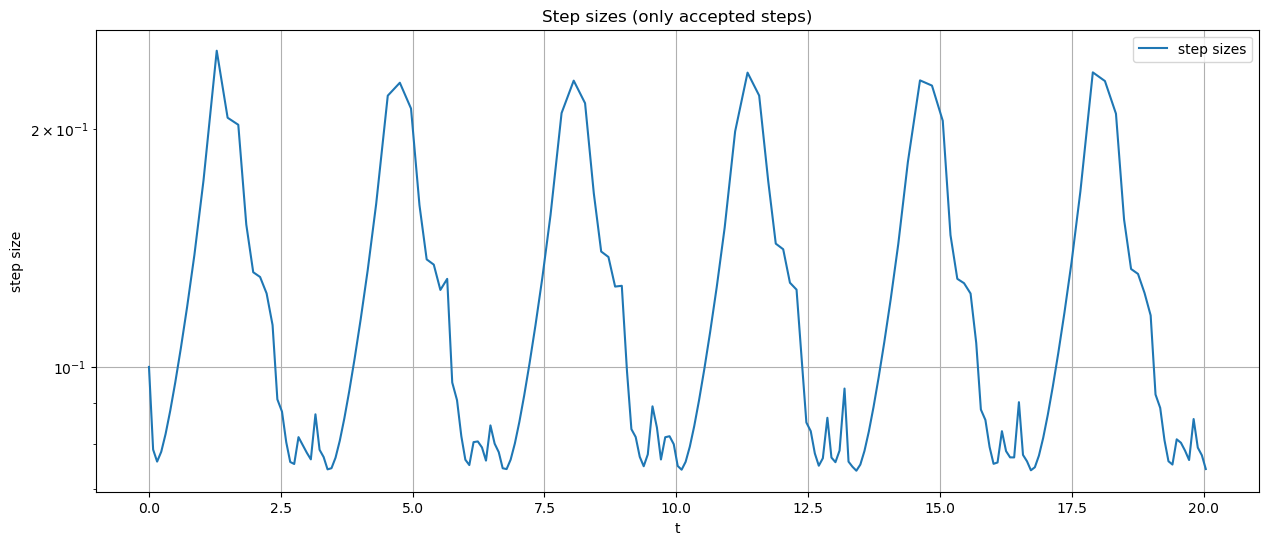

In [206]:
importlib.reload(aRK)
step_sizes_Fehlberg, y_Fehlberg, t, cnt_accepted, cnt_rejected = aRK.embedded_adaptive_RK(f, start_values(), 0, t_f, 0.1, 1e-6, 0.1, 5, 0.9, len(A), A, b1, b2, c)

print_acceptance_stats("Fehlberg", cnt_accepted, cnt_rejected)
# Plotting the solution
plot_solution(t, y_Fehlberg, step_sizes_Fehlberg, "Fehlberg", exact_solution)

## Dormand-Prince method

In [207]:
# Dormand-Prince
import numpy as np

A = np.array([
    [0., 0., 0., 0., 0., 0., 0.],
    [1/5, 0., 0., 0., 0., 0., 0.],
    [3/40, 9/40, 0., 0., 0., 0., 0.],
    [44/45, -56/15, 32/9, 0., 0., 0., 0.],
    [19372/6561, -25360/2187, 64448/6561, -212/729, 0., 0., 0.],
    [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0., 0.],
    [35/384, 0., 500/1113, 125/192, -2187/6784, 11/84, 0.]
])

c = np.array([0.0, 1/5, 3/10, 4/5, 8/9, 1.0, 1.0])

b1 = np.array([5179/57600, 0., 7571/16695, 393/640, -92097/339200, 187/2100, 1/40])
b2 = np.array([35/384, 0., 500/1113, 125/192, -2187/6784, 11/84, 0.])


0.1
Dormand-Prince method: Accepted steps = 165, Rejected steps = 47, Acceptance ratio = 0.78


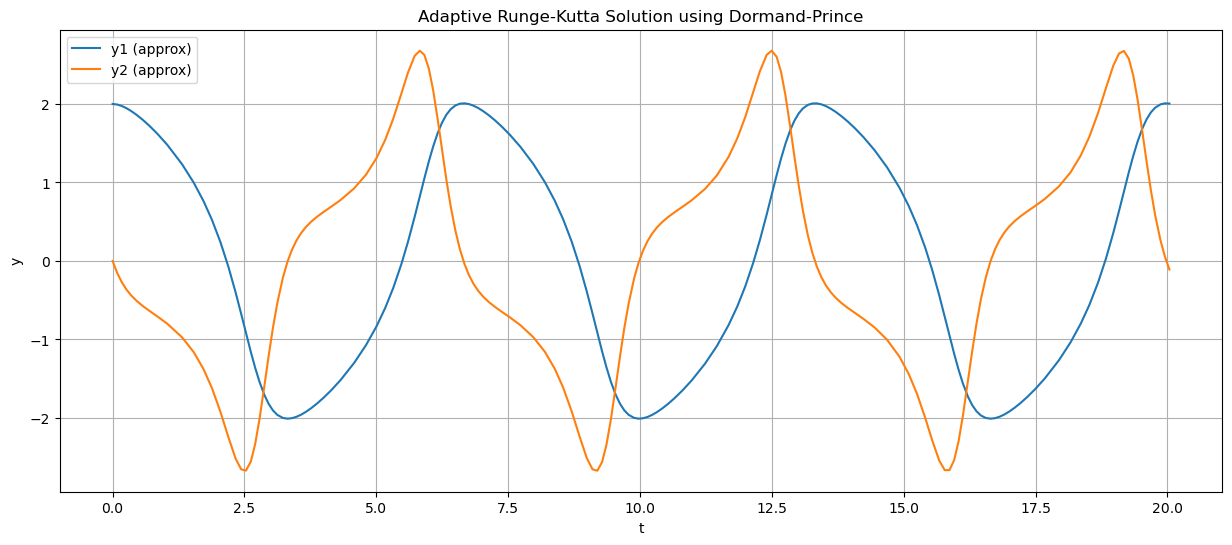

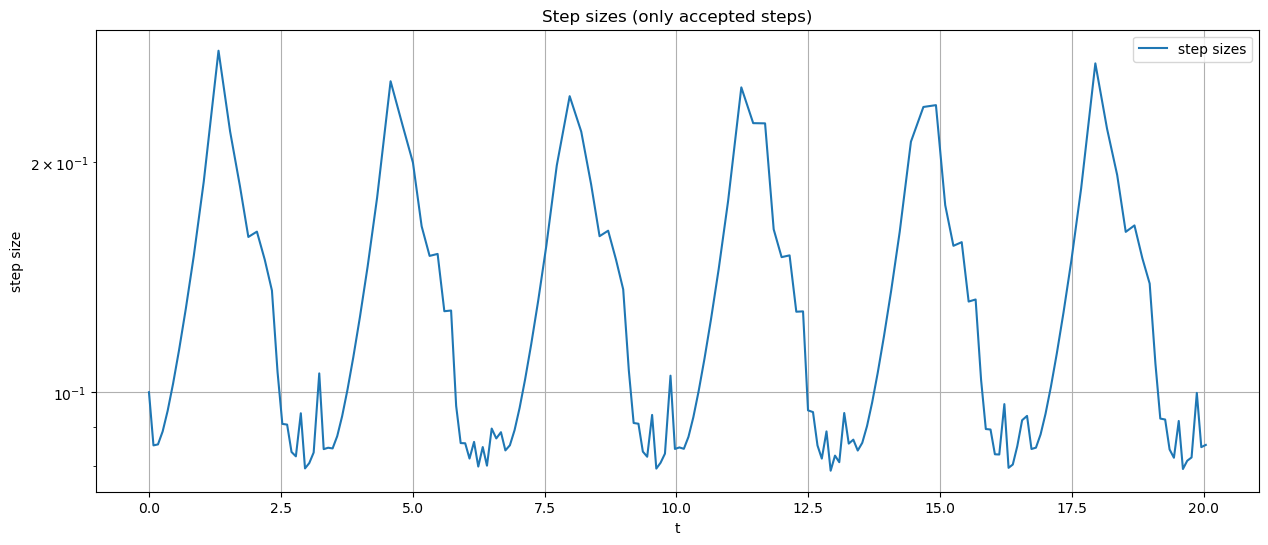

In [208]:
importlib.reload(aRK)
step_sizes_DP, y_DP, t, cnt_accepted, cnt_rejected = aRK.embedded_adaptive_RK(f, start_values(), 0, t_f, 0.1, 1e-6, 0.1, 1.5, 0.9, len(A), A, b1, b2, c)

print_acceptance_stats("Dormand-Prince", cnt_accepted, cnt_rejected)
# Plotting the solution
plot_solution(t, y_DP, step_sizes_DP, "Dormand-Prince", exact_solution)

## Richardson extrapolation

In [209]:
# RK4
A = np.array([
    [0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.0, 0.0],
    [0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])
c = np.array([0.0, 0.5, 0.5, 1.0])
b = np.array([1/6, 1/3, 1/3, 1/6])

Richardson extrapolation method: Accepted steps = 160, Rejected steps = 46, Acceptance ratio = 0.78


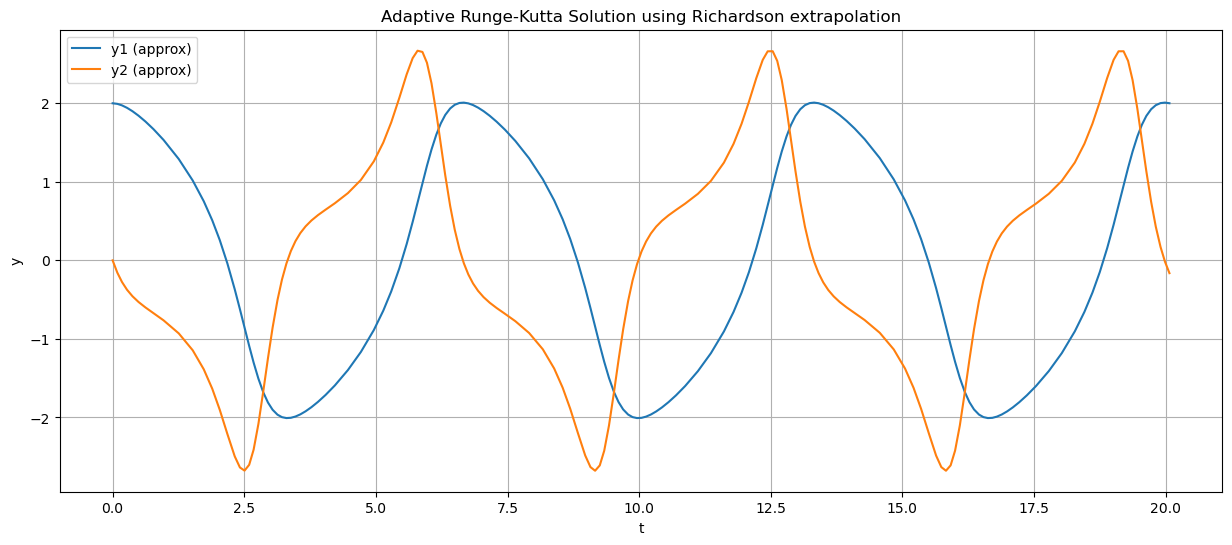

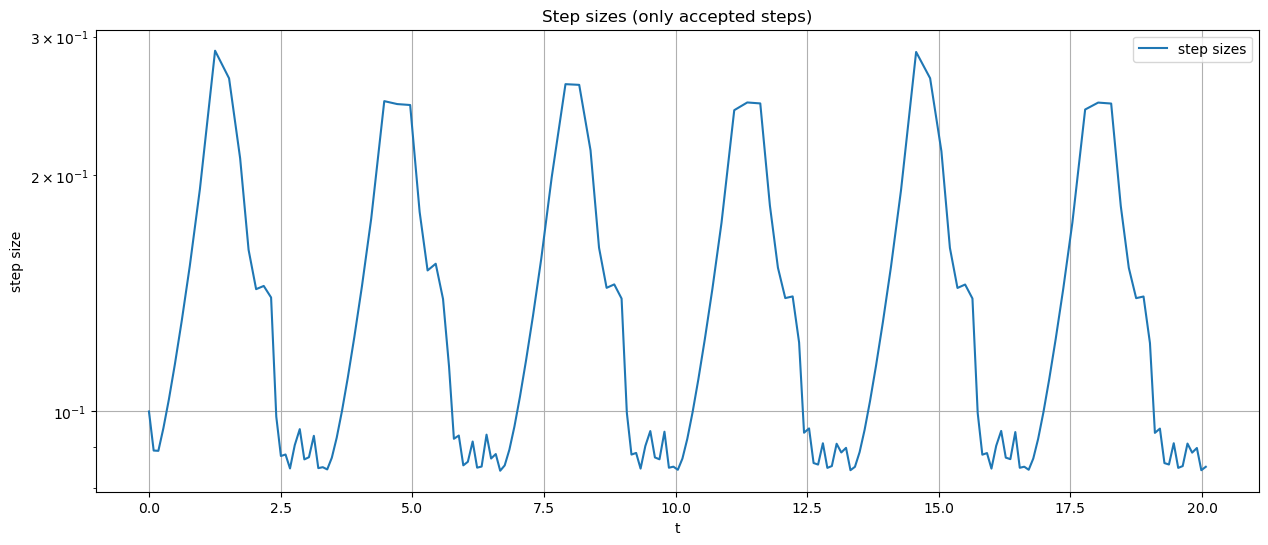

In [210]:
importlib.reload(aRK)

step_sizes_Richardson, y_Richardson, t, cnt_accepted, cnt_rejected = aRK.adaptive_Richardson_RK(f, start_values(), 0, t_f, 0.1, 1e-6, 0.1, 1.5, 0.9, len(A), A, b, c)

print_acceptance_stats("Richardson extrapolation", cnt_accepted, cnt_rejected)
# Plotting the solution
plot_solution(t, y_Richardson, step_sizes_Richardson, "Richardson extrapolation", exact_solution)

## Using controllers

Fehlberg with PI3333 controller method: Accepted steps = 175, Rejected steps = 288, Acceptance ratio = 0.38


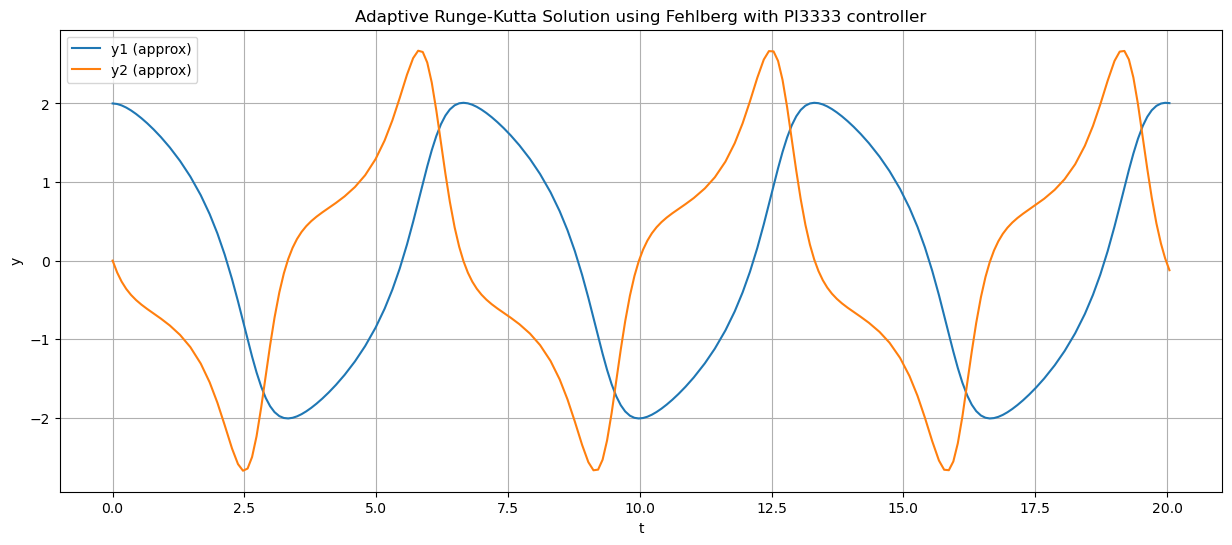

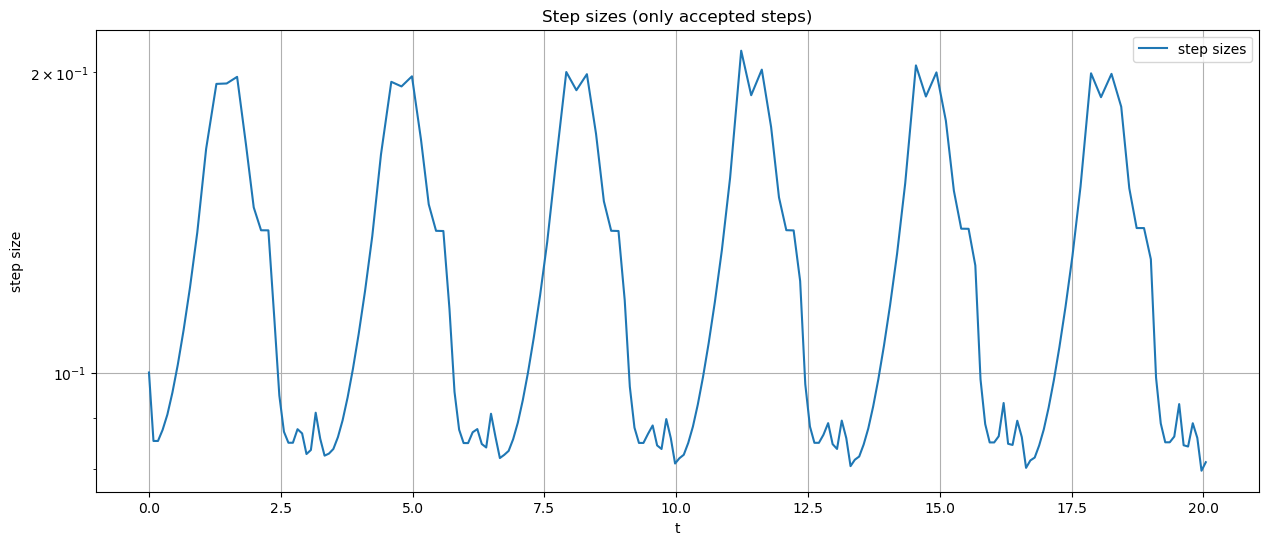

In [211]:
A, b1, b2, c = set_Fehlberg_tableau()
# Possible controllers: "I", "PI", "PID", "PI3333", "H211"
controller = "PI3333" 

importlib.reload(aRK)
step_sizes_Fehlberg_ctrl, y_Fehlberg_ctrl, t, cnt_accepted, cnt_rejected = aRK.adaptive_RK_with_controller(
    f, start_values(), 0, t_f, .1, 1e-6, controller, len(A), A, b1, b2, c)

print_acceptance_stats(f"Fehlberg with {controller} controller", cnt_accepted, cnt_rejected)
# Plotting the solution
plot_solution(t, y_Fehlberg_ctrl, step_sizes_Fehlberg_ctrl, f"Fehlberg with {controller} controller", exact_solution)

In [212]:
A, b1, b2, c = set_Fehlberg_tableau()
# Possible controllers: "I", "PI", "PID", "PI3333", "H211"
controller = "H211" 

importlib.reload(aRK)
step_sizes_Fehlberg_ctrl, y_Fehlberg_ctrl, t, cnt_accepted, cnt_rejected = aRK.adaptive_RK_with_controller(
    f, start_values(), 0, t_f, .1, 1e-6, controller, len(A), A, b1, b2, c)

print_acceptance_stats(f"Fehlberg with {controller} controller", cnt_accepted, cnt_rejected)
# Plotting the solution
plot_solution(t, y_Fehlberg_ctrl, step_sizes_Fehlberg_ctrl, f"Fehlberg with {controller} controller", exact_solution)

KeyboardInterrupt: 